# Aula 4

## Brevíssima introdução à utilização do SCIP em Python

A documentação do PySCIPOpt, a biblioteca Python de interface para o solver SCIP para Programação Inteira, pode ser encontrada em http://scip-interfaces.github.io/PySCIPOpt/docs/html/

Para criar um problema de programação inteira é necessário começar por criar um problema vazio usando a função `Model()`.

Para adicionar variáveis a este problema usa-se o método `addVar`. Os tipos possíveis para as variáveis são `BINARY`, `INTEGER` ou `CONTINUOUS` (podem ser abreviados por `B`, `I`, ou `C`), definidos com o parâmetro `vtype`. Também possível definir limites inferiores e superiores para estas variáveis usando os parâmetros `lb` e `ub`. Por omissão as variáveis são do tipo `CONTINUOUS` e o limite inferior é 0.

Para adicionar restrições usa-se o método `addCons`. Este método só aceita mesmo equações lineares com igualdade, maior ou igual, ou menor ou igual. Por exemplo, não é possível adicionar restrições a dizer que duas variáveis inteiras são diferentes. Para construir uma soma de todas as expressões numa lista pode usar-se a função `quicksum`.

O método `setObjective` serve para definir uma função objectivo para minimizar ou maximizar. O sentido da optimização pode ser definido com o parâmetro `sense`, cujos valores podem ser `minimize` ou `maximize`.

Para resolver um problema usa-se o método `optimize`. Depois de executado este método pode usar-se o método `getStatus` para saber o resultado, que pode ser: `optimal`, `infeasible`, `unbounded`, `timelimit` or `unknown`.

Se o resultado for `optimal` pode-se extrair o valor de uma variável com o método `getVal`.

In [2]:
from pyscipopt import Model,quicksum

Por exemplo, o programa seguinte tenta encontrar $x$ e $y$ que minimizem $3x+4y$ satisfazendo as seguintes restrições:

$$
\left\{
\begin{array}{l}
5x + 6y \ge 11\\
7x + 5y \ge 5\\
x \ge 0\\
y \ge 0
\end{array}
\right.
$$

In [3]:
m = Model()
x = m.addVar("x")
y = m.addVar("y")
m.addCons(5*x + 6*y >= 11)
m.addCons(7*x + 5*y >= 5)
m.setObjective(3*x + 4*y,"minimize")
m.optimize()
if m.getStatus() == 'optimal':
    print ("x = ",m.getVal(x))
    print ("y = ",m.getVal(y))

x =  2.2
y =  0.0


## Modelação da coloração de grafos com Programação Inteira

Recorde a função definida na aula anterior para desenhar grafos tendo em atenção a cor dos vértices.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_with_colors(graph):
    nx.draw(graph, with_labels = True, node_color=[graph.nodes[v]['color'] for v in graph])
    
petersen = nx.petersen_graph()

### Exercício 1

Recorde a modelação do problema de coloração de grafos que fez na aula anterior, usando lógica proposicional.
Como sabe, podemos reduzir as restições proposicionais a restrições aritméticas em aritmética linear.
Podemos assim ver o problema da coloração de grafos como um problema de Programação Inteira. Defina o método seguinte que testa se é possível colorir um grafo com $k$ cores usando o SCIP. Se for possível, deve guardar a coloração no grafo (no atributo `color`).

Note que a teoria de inteiros em SCIP não permite codificar a negação, logo não vai ser possível usar variáveis inteiras na gama $[0..k-1]$ para representar a cor dos vértices. Em vez disso, terá que usar variáveis binárias, codificando o problema de forma semelhante à codificação em Lógica Proposicional, ou seja, usando uma variável binária $x_{v,c}$ para indicar que o vértice $v$ tem cor $c$.

/home/jc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


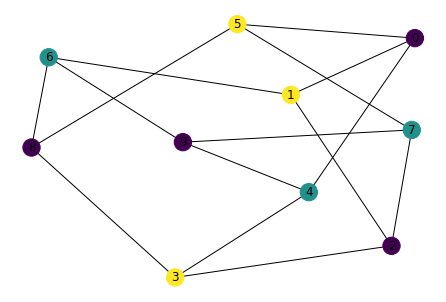

In [5]:
def ip_color(graph,k):
    
    # criar as variaveis x, v, c;
    m = Model();
    x = {};
    for v in graph:
        x[v] = {}
        for c in range(k):
            x[v][c] = m.addVar(str(v) + str(c), vtype = 'B')
    
    # vértices adjacentes têm cores diferentes;
    for o in graph:
        for d in graph[o]:
            for c in range(k):
                m.addCons(x[o][c] + x[d][c] <= 1)
    
    # vértices têm exactamente uma cor;
    for v in graph:
        m.addCons(quicksum([x[v][c] for c in range(k)]) == 1)
    
    # testar a satisfazibilidade e fazer a coloração do grafo, se possível;
    m.optimize()
    if m.getStatus() == 'optimal':
        for v in graph:
            for c in range(k):
                if m.getVal(x[v][c]) == 1:
                    graph.node[v]['color'] = c
                    break
        return True
    elif m.getStatus() == 'infeasible':
        return False
    
assert ip_color(petersen,3)
draw_with_colors(petersen)

### Exercício 2

Compare a eficiência das três implementações que foram feitas para o problema de decisão da coloração. Sugere-se que utilize grafos completos nessa comparação: nestes grafos o número cromático é igual ao número de vértices.

### Exercício 3

Como o SCIP suporta problemas de optimização em programação inteira, podemos implementar directamente o problema de optimização da coloração de grafos sem usar um método de pesquisa linear que tenta todos os possíveis números cromáticos. O objectivo deste exercício é implementar este problema em SCIP, ou seja, determinar uma coloração válida que minimize o número de cores.

Sugere-se que, para além das variáveis binárias que usou no exercício 1, utilize uma variável binárias $u_c$ por cada cor $c$ possível (note que num grafo $(V,E)$ o número máximo de cores necessário será idêntico ao número de vértices $|V|$). Esta variável deve ter o valor 1 sse a cor $c$ for usada nalgum vértice. Dado este conjunto de variáveis o objectivo da optimização será minimizar:

$$
\sum_{c = 0}^{|V|-1} u_c
$$

O valor de cada variável $u_c$ pode ser definido como o valor máximo das variáveis $x_{v,c}$ para todo o vértice $v$.

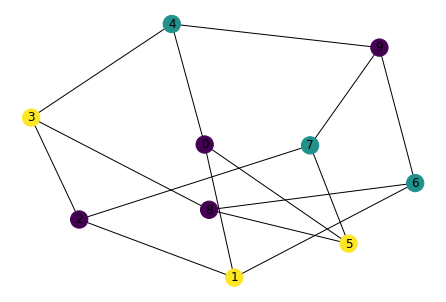

In [17]:
def find_optimal_color(graph):
    
    # criar as variaveis x, v, c;
    m = Model()
    x = {}
    for v in graph:
        x[v] = {}
        for c in range(len(graph)):
            x[v][c] = m.addVar(str(v) + str(c), vtype = 'B')
            
    # criar as variáveis u_{c}
    u = {}
    for c in range(len(graph)):
        u[c] = m.addVar(str(u) + str(c), vtype = 'B')
    
    # vértices adjacentes têm cores diferentes;
    for o in graph:
        for d in graph[o]:
            for c in range(len(graph)):
                m.addCons(x[o][c] + x[d][c] <= 1)
    
    # vértices têm exactamente uma cor;
    for v in graph:
        m.addCons(quicksum([x[v][c] for c in range(len(graph))]) == 1)
    
    # u_{c} indica que a cor está a ser usada
    for c in range(len(graph)):
        for v in graph:
            m.addCons(x[v][c] <= u[c])
    
    m.setObjective(quicksum(u.values()),"minimize")
    
    # testar a satisfazibilidade e fazer a coloração do grafo, se possível;
    m.optimize()
    if m.getStatus() == 'optimal':
        for v in graph:
            for c in range(len(graph)):
                if m.getVal(x[v][c]) == 1:
                    graph.node[v]['color'] = c
                    break
        return sum([ m.getVal(u[c]) for c in range(len(graph)) ])
        #return sum(list(u.values()))

assert find_optimal_color(petersen) == 3
draw_with_colors(petersen)